# Compressed sensing

How does the generalization error depend on the number of neurons recorded?

In [1]:
import numpy as np
from numpy import random

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})
sns.set_style('ticks')

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import os
root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
# names = np.load(root + 'names.npy')

model = 'resnet50'
model_dir = os.path.join(root, model)

# Helper functions

In [4]:
# Compute error
m = 5
n_avg = 2000

def compute_err(manifolds,m):
    err_all = np.zeros((len(manifolds),len(manifolds)))
    err_std = np.zeros((len(manifolds),len(manifolds)))
    for a in range(len(manifolds)):
        Xa = manifolds[a]
        for b in range(len(manifolds)):
            Xb = manifolds[b]

            errs = []
            for _ in range(n_avg):
                perma = np.random.permutation(len(Xa))
                permb = np.random.permutation(len(Xb))

                xa,ya = np.split(Xa[perma],(m,))
                xb,yb = np.split(Xb[permb],(m,))
                w = (xa-xb).mean(0)
                mu = (xa+xb).mean(0)/2

                h = ya@w - w@mu
                err = (h<0).mean()
                errs.append(err)
            err_all[a,b] = np.mean(errs)
            err_std[a,b] = np.std(errs)
    np.fill_diagonal(err_all,np.nan)
    
    return err_all, err_std




def geometry(manifolds,m):
    Rs = []
    centers = []
    Us = []
    for manifold in manifolds:
        centers.append(manifold.mean(0))
        U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
        Rs.append(R)
        Us.append(V)
    Rs = np.stack(Rs)
    centers = np.stack(centers)
    Us = np.stack(Us)
    
    K = len(centers)
    P = Rs.shape[1]
    dists = np.sqrt(((centers[:,None] - centers[None])**2).sum(-1))
    dist_norm = dists / np.sqrt((Rs**2).sum(-1)[:,None] / P)

    Ds = np.sum(Rs**2,axis=-1)**2 / np.sum(Rs**4, axis=-1)

    # Center-subspace
    csa = []
    csb = []
    for a in range(K):
        for b in range(K):
            if a!=b:
                dx0 = centers[a] - centers[b]
                dx0hat = dx0 / np.linalg.norm(dx0)
                costheta_a = Us[a]@dx0hat
                csa.append((costheta_a**2 * Rs[a]**2).sum() / (Rs[a]**2).sum())
                costheta_b = Us[b]@dx0hat
                csb.append((costheta_b**2 * Rs[b]**2).sum() / (Rs[a]**2).sum())
            else:
                csa.append(np.nan)
                csb.append(np.nan)
    csa = np.stack(csa).reshape(K,K)
    csb = np.stack(csb).reshape(K,K)

    # Subspace-subspace
    ss = []
    for a in range(K):
        for b in range(K):
            if a!=b:
                cosphi = Us[a]@Us[b].T
                ss_overlap = (cosphi**2*Rs[a][:,None]**2*Rs[b]**2).sum() / (Rs[a]**2).sum()**2
                ss.append(ss_overlap)
            else:
                ss.append(np.nan)
    ss = np.stack(ss).reshape(K,K)

    css = (csa + csb/m) * dist_norm**2

    bias = (Rs**2).sum(-1) / (Rs**2).sum(-1)[:,None] - 1
    SNR = 1/2*(dist_norm**2 + bias/m)/ np.sqrt(1/Ds[:,None]/m + css + ss/m)
    
    return dist_norm, Ds, csa, ss, SNR


from scipy.special import erfc

def H(x):
    return 1/2*erfc(x/np.sqrt(2))

# Manifolds

In [5]:
manifolds_load = np.load(os.path.join(model_dir,'manifolds.npy'),allow_pickle=True)

In [6]:
P = 500
manifolds = []
for manifold in manifolds_load[:100]:
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [106]:
Ms = np.logspace(2,8.9,8,base=2)
Ms

array([  4.        ,   7.92117409,  15.68624976,  31.06337881,
        61.51460788, 121.81697959, 241.23337574, 477.71289167])

In [107]:
m = 5
N = 2048
K = manifolds.shape[0]
# Ms = np.logspace(3,11,8,base=2)
Ms = np.logspace(2,8.9,8,base=2)

n_avg = 1
Dsvds = []
SNRs = []
err_all = []

Dsvds_proj = []
SNRs_proj = []
err_all_proj = []
for M in tqdm(Ms):
    for _ in tqdm(range(n_avg),leave=False):
        # Random sample
        idxs = np.random.choice(N,int(M),replace=False)
        manifolds_small = manifolds[:,:,idxs]
        dist_norm, Ds, csa, ss, SNR = geometry(manifolds_small, m)
        Dsvds.append(Ds)
        SNRs.append(SNR)
        err, err_std = compute_err(manifolds_small,m)
        err_all.append(err)
        
        # Random projection
        A = np.random.randn(N,int(M)) / np.sqrt(M)
        manifolds_small = manifolds@A 
        dist_norm, Ds, csa, ss, SNR = geometry(manifolds_small, m)
        Dsvds_proj.append(Ds)
        SNRs_proj.append(SNR)
        err, err_std = compute_err(manifolds_small,m)
        err_all_proj.append(err)
Dsvds = np.stack(Dsvds).reshape(len(Ms),n_avg,K).mean(1)
SNRs = np.nanmean(np.stack(SNRs).reshape(len(Ms),n_avg,-1),1)
err_all = np.nanmean(np.stack(err_all).reshape(len(Ms),n_avg,-1),1)
Dsvds_proj = np.stack(Dsvds_proj).reshape(len(Ms),n_avg,K).mean(1)
SNRs_proj = np.nanmean(np.stack(SNRs_proj).reshape(len(Ms),n_avg,-1),1)
err_all_proj = np.nanmean(np.stack(err_all_proj).reshape(len(Ms),n_avg,-1),1)

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


In [69]:
cs_dir = os.path.join(model_dir,'compressed_sensing')
# if not os.path.isdir(cs_dir):
#     os.mkdir(cs_dir)
# np.save(os.path.join(cs_dir, 'Ms.npy'), Dsvds)
# np.save(os.path.join(cs_dir, 'SNRs.npy'), SNRs)
# np.save(os.path.join(cs_dir, 'err_all.npy'), err_all)
# np.save(os.path.join(cs_dir, 'Ms_proj.npy'), Dsvds_proj)
# np.save(os.path.join(cs_dir, 'SNRs_proj.npy'), SNRs_proj)
# np.save(os.path.join(cs_dir, 'err_all_proj.npy'), err_all_proj)

In [108]:
# Asymptotic Dsvd
Ds0 = (Ms[-1]*Dsvds[-1]-1)/ (Ms[-1]-Dsvds[-1])
Ds0_proj = (Ms[-1]*Dsvds_proj[-1]-1)/ (Ms[-1]-Dsvds_proj[-1])

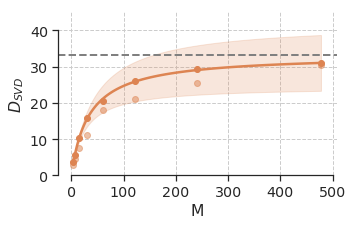

In [113]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(5,3))
# Ms = np.logspace(2,11,100, base=2)
MMs = np.logspace(np.log2(np.min(Ms)),np.log2(np.max(Ms)),100,base=2)
Ds_pred = Ds0_proj / (1+Ds0_proj/MMs[:,None])
plt.plot(MMs, Ds_pred.mean(1),c='C1');
plt.fill_between(MMs, Ds_pred.mean(1)+Ds_pred.std(1),Ds_pred.mean(1)-Ds_pred.std(1),
                alpha=0.2,color='C1');

# Ms = np.logspace(3,11,8,base=2)
plt.scatter(Ms, Dsvds_proj.mean(-1),c='C1', label='Random projection')
plt.scatter(Ms, Dsvds.mean(-1),c='C1', alpha=0.5, label='Random sampling')

plt.axhline(Ds0_proj.mean(), c='grey', linestyle='dashed', linewidth=2)
# plt.xscale('log')
plt.grid(True, which='both',ls='--')
plt.xlabel('M')
plt.ylabel(r'$D_{SVD}$')
# plt.xlim([-10,250])
plt.ylim([0,45])
sns.despine(trim=True)

# # Inset
# axins = inset_axes(ax, width="50%", height="40%",loc=4, borderpad=2)
# Ms = np.logspace(2,11,100, base=2)
# Ds_pred = Ds0 / (1+Ds0/Ms[:,None])
# plt.plot(Ms, Ds_pred.mean(1), c='C1');
# plt.fill_between(Ms, Ds_pred.mean(1)+Ds_pred.std(1),Ds_pred.mean(1)-Ds_pred.std(1),
#                 alpha=0.2,color='C1');

# Ms = np.logspace(3,11,8,base=2)
# plt.scatter(Ms, Dsvds_proj.mean(-1),c='C1', )
# plt.scatter(Ms, Dsvds.mean(-1),c='C1', alpha=0.5)


# plt.axhline(Ds0.mean(), c='grey', linestyle='dashed', linewidth=2)
# plt.xscale('log')
# plt.grid(True, which='both',ls='--')
# sns.despine(trim=True)


plt.savefig('images/random_proj_D_500.pdf')

In [110]:
from scipy.special import erfinv
def Hinv(z):
    return np.sqrt(2)*erfinv(1-2*z)

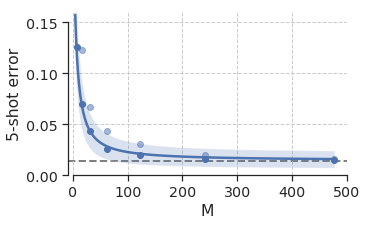

In [112]:
fig, ax = plt.subplots(figsize=(5,3))
MMs = np.logspace(np.log2(np.min(Ms)),np.log2(np.max(Ms)),100,base=2)
SNR0 = Hinv(err_all[-1]) * np.sqrt(1+np.repeat(Ds0_proj,K)/MMs[-1])
SNR_pred = SNR0 / np.sqrt(1+np.repeat(Ds0_proj,K)/MMs[:,None])
plt.plot(MMs, np.nanmean(H(SNR_pred),-1))
std = np.nanmean(H(SNR_pred).reshape(-1,100,100),1).std(-1)
plt.fill_between(MMs, np.nanmean(H(SNR_pred),-1)+std,
                np.nanmean(H(SNR_pred),-1)-std,
                alpha=0.2);

plt.scatter(Ms, np.nanmean(err_all_proj,-1),c='C0')
plt.scatter(Ms, np.nanmean(err_all,-1),c='C0',alpha=0.5)
plt.axhline(np.nanmean(H(SNR0)), linestyle='dashed', c='grey',linewidth=2,zorder=0)

plt.grid(True, which='both',ls='--')
plt.xlabel('M')
plt.ylabel(str(m)+'-shot error')
plt.xlim([-10,500])
plt.ylim([0,0.16])
sns.despine(trim=True)


# # Inset
# axins = inset_axes(ax, width="60%", height="50%",loc=1, borderpad=0.5)
# Ms = np.logspace(2,11,100, base=2)
# SNR0 = Hinv(err_all[-1]) * np.sqrt(1+np.repeat(Ds0,K)/Ms[-1])
# plt.axhline(np.nanmean(H(SNR0)), linestyle='dashed', c='grey', linewidth=2)
# SNR_pred = SNR0 / np.sqrt(1+np.repeat(Ds0,K)/Ms[:,None])
# plt.plot(Ms, np.nanmean(H(SNR_pred),-1))
# plt.fill_between(Ms, np.nanmean(H(SNR_pred),-1)+std,
#                 np.nanmean(H(SNR_pred),-1)-std,
#                 alpha=0.2);
# Ms = np.logspace(3,11,8,base=2)
# plt.scatter(Ms, np.nanmean(err_all_proj,-1),c='C0')
# plt.scatter(Ms, np.nanmean(err_all,-1),c='C0',alpha=0.5)
# plt.xscale('log')
# plt.grid(True, which='both',ls='--')

plt.savefig('images/random_proj_err_500.pdf')

# IT cortex

In [114]:
import os
manifolds =  np.load('/mnt/fs2/bsorsch/manifold/embeddings_new/macaque/manifolds_IT.npy')

In [141]:
m = 5
N = 168
K = manifolds.shape[0]
Ms = np.logspace(2,7,8,base=2)
n_avg = 50
Dsvds = []
SNRs = []
err_all = []

Dsvds_proj = []
SNRs_proj = []
err_all_proj = []
for M in tqdm(Ms):
    for _ in tqdm(range(n_avg),leave=False):
        # Random sample
        idxs = np.random.choice(N,int(M),replace=False)
        manifolds_small = manifolds[:,:,idxs]
        dist_norm, Ds, csa, ss, SNR = geometry(manifolds_small, m)
        Dsvds.append(Ds)
        SNRs.append(SNR)
        err, err_std = compute_err(manifolds_small,m)
        err_all.append(err)
        
        # Random projection
        A = np.random.randn(N,int(M)) / np.sqrt(M)
        manifolds_small = manifolds@A 
        dist_norm, Ds, csa, ss, SNR = geometry(manifolds_small, m)
        Dsvds_proj.append(Ds)
        SNRs_proj.append(SNR)
        err, err_std = compute_err(manifolds_small,m)
        err_all_proj.append(err)
Dsvds = np.stack(Dsvds).reshape(len(Ms),n_avg,K).mean(1)
SNRs = np.nanmean(np.stack(SNRs).reshape(len(Ms),n_avg,-1),1)
err_all = np.nanmean(np.stack(err_all).reshape(len(Ms),n_avg,-1),1)
Dsvds_proj = np.stack(Dsvds_proj).reshape(len(Ms),n_avg,K).mean(1)
SNRs_proj = np.nanmean(np.stack(SNRs_proj).reshape(len(Ms),n_avg,-1),1)
err_all_proj = np.nanmean(np.stack(err_all_proj).reshape(len(Ms),n_avg,-1),1)

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice


In [142]:
# Asymptotic Dsvd
Ds0 = (Ms[-1]*Dsvds[-1]-1)/ (Ms[-1]-Dsvds[-1])
Ds0_proj = (Ms[-1]*Dsvds_proj[-1]-1)/ (Ms[-1]-Dsvds_proj[-1])

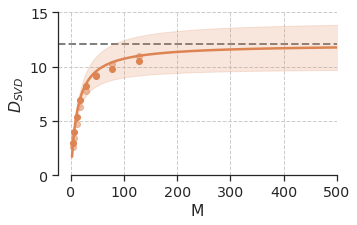

In [143]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(5,3))
MMs = np.logspace(np.log2(np.min(Ms)-2),9,100,base=2)
Ds_pred = Ds0 / (1+Ds0/MMs[:,None])
plt.plot(MMs, Ds_pred.mean(1),c='C1');
plt.fill_between(MMs, Ds_pred.mean(1)+Ds_pred.std(1),Ds_pred.mean(1)-Ds_pred.std(1),
                alpha=0.2,color='C1');

plt.scatter(Ms, Dsvds_proj.mean(-1),c='C1', label='Random projection')
plt.scatter(Ms, Dsvds.mean(-1),c='C1', alpha=0.5, label='Random sampling')

plt.axhline(Ds0.mean(), c='grey', linestyle='dashed', linewidth=2,zorder=0)
# plt.xscale('log')
plt.grid(True, which='both',ls='--')
plt.xlabel('M')
plt.ylabel(r'$D_{SVD}$')
plt.xlim([-25,500])
plt.yticks([0,5,10,15])
sns.despine(trim=True)

# # Inset
# axins = inset_axes(ax, width="50%", height="40%",loc=4, borderpad=2)
# Ds_pred = Ds0 / (1+Ds0/MMs[:,None])
# plt.plot(MMs, Ds_pred.mean(1), c='C1');
# plt.fill_between(MMs, Ds_pred.mean(1)+Ds_pred.std(1),Ds_pred.mean(1)-Ds_pred.std(1),
#                 alpha=0.2,color='C1');

# plt.scatter(Ms, Dsvds_proj.mean(-1),c='C1', )
# plt.scatter(Ms, Dsvds.mean(-1),c='C1', alpha=0.5)


# plt.axhline(Ds0.mean(), c='grey', linestyle='dashed', linewidth=2)
# plt.xscale('log')
# plt.grid(True, which='both',ls='--')
# # sns.despine(trim=True)
# axins.set_xlim([3,250])


# plt.savefig('images/IT_random_proj_D_500.pdf')

In [144]:
from scipy.special import erfinv
def Hinv(z):
    return np.sqrt(2)*erfinv(1-2*z)

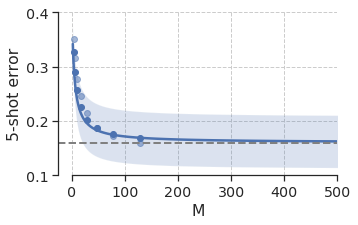

In [145]:
fig, ax = plt.subplots(figsize=(5,3))
# SNR0 = Hinv(err_all[-1]) * np.sqrt(1+np.repeat(Ds0,K)/Ms[-1])
SNR0 = Hinv(err_all[-1])
SNR_pred = SNR0 / np.sqrt(1+np.repeat(Ds0,K)/MMs[:,None])
plt.plot(MMs, np.nanmean(H(SNR_pred),-1))
std = np.nanmean(H(SNR_pred).reshape(-1,K,K),1).std(-1)
plt.fill_between(MMs, np.nanmean(H(SNR_pred),-1)+std,
                np.nanmean(H(SNR_pred),-1)-std,
                alpha=0.2);

plt.scatter(Ms, np.nanmean(err_all_proj,-1),c='C0')
plt.scatter(Ms, np.nanmean(err_all,-1),c='C0',alpha=0.5)
plt.axhline(np.nanmean(H(SNR0)), linestyle='dashed', c='grey',linewidth=2)

plt.grid(True, which='both',ls='--')
plt.xlabel('M')
plt.ylabel(str(m)+'-shot error')
plt.xlim([-25,500])
plt.yticks([0.1,0.2,0.3,0.4])
sns.despine(trim=True)

# # Inset
# axins = inset_axes(ax, width="60%", height="40%",loc=1, borderpad=0.5)
# SNR0 = Hinv(err_all[-1]) * np.sqrt(1+np.repeat(Ds0,K)/Ms[-1])
# plt.axhline(np.nanmean(H(SNR0)), linestyle='dashed', c='grey', linewidth=2)
# SNR_pred = SNR0 / np.sqrt(1+np.repeat(Ds0,K)/MMs[:,None])
# plt.plot(MMs, np.nanmean(H(SNR_pred),-1))
# plt.fill_between(MMs, np.nanmean(H(SNR_pred),-1)+std,
#                 np.nanmean(H(SNR_pred),-1)-std,
#                 alpha=0.2);

# plt.scatter(Ms, np.nanmean(err_all_proj,-1),c='C0')
# plt.scatter(Ms, np.nanmean(err_all,-1),c='C0',alpha=0.5)
# axins.set_xlim([3,250])
# plt.xscale('log')
# plt.grid(True, which='both',ls='--')

# plt.savefig('images/IT_random_proj_err_500.pdf')

In [62]:
1-np.nanmean(err_all[-1])

0.7157456420068027

In [11]:
np.cos(2)

-0.4161468365471424

In [162]:
m = 10
D = 500
P = 1000
X = np.random.randn(m,D,P)
X /= np.linalg.norm(X,axis=1,keepdims=True)
Y = np.random.randn(m,D,P)
Y /= np.linalg.norm(Y,axis=1,keepdims=True)
d = ((X-Y)**2).sum(1)

In [163]:
2 - np.sqrt(4*np.log(m)/D)

1.8642771915116978

In [164]:
np.mean(d.min(0))

1.8654391030159814

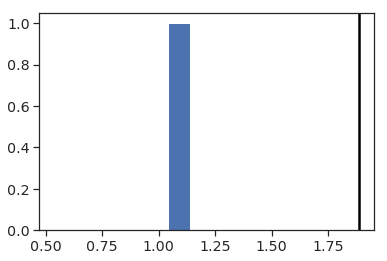

In [137]:
plt.hist(d.min(0))
plt.axvline(2 - np.sqrt(4*np.log(m)/D), c='black')

In [148]:
m = 10
D = 500
P = 10000
X = np.random.randn(m,D,P)
X /= np.linalg.norm(X,axis=1,keepdims=True)
Y = np.random.randn(D,P)
Y /= np.linalg.norm(Y,axis=0,keepdims=True)
d = ((X.mean(0)-Y)**2).sum(0)

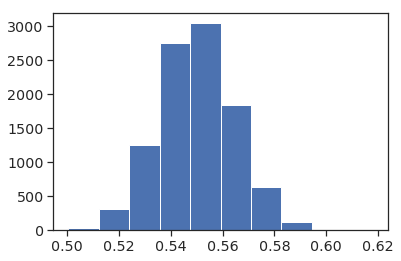

In [149]:
plt.hist(d);

In [146]:
np.mean(d)

1.099851289114848

In [147]:
1+1/m

1.1

In [123]:
4/D/m

0.0004